<a href="https://colab.research.google.com/github/nrimsky/mlexperiments/blob/main/modular_addition/reverse_engineering_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [319]:
!pip install einops

In [320]:
import torch as t
import einops
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from torch.autograd import grad

# Training a very basic modular addition network

## Define some constants

In [321]:
P = 53
TRAIN_FRAC = 0.7
HIDDEN_SIZE = 32
LR = 0.01
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
BATCH_SIZE = 256

## Setup - prepare a dataset of 1-hot embedded numbers added together mod $p$

In [322]:
def embed_number(n, p):
  embedded = t.zeros((p,))
  embedded[n] = 1
  return embedded

In [323]:
embed_number(2, 10)

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [324]:
def get_all_pairs(p):
  pairs = []
  for i in range(p):
    for j in range(p):
      pairs.append((i,j))
  return set(pairs)


In [325]:
def make_dataset(p):
  data = []
  pairs = get_all_pairs(p)
  for a, b in pairs:
    inp = t.cat((embed_number(a, p), embed_number(b, p)))
    data.append((inp, t.tensor((a + b) % p)))
  return data


In [326]:
make_dataset(3)

[(tensor([1., 0., 0., 0., 1., 0.]), tensor(1)),
 (tensor([0., 1., 0., 0., 0., 1.]), tensor(0)),
 (tensor([0., 0., 1., 0., 1., 0.]), tensor(0)),
 (tensor([1., 0., 0., 1., 0., 0.]), tensor(0)),
 (tensor([0., 1., 0., 0., 1., 0.]), tensor(2)),
 (tensor([0., 0., 1., 1., 0., 0.]), tensor(2)),
 (tensor([1., 0., 0., 0., 0., 1.]), tensor(2)),
 (tensor([0., 0., 1., 0., 0., 1.]), tensor(1)),
 (tensor([0., 1., 0., 1., 0., 0.]), tensor(1))]

In [327]:
def train_test_split(dataset, train_split_proportion):
  l = len(dataset)
  train_len = int(train_split_proportion * l)
  idx = list(range(l))
  random.shuffle(idx)
  train_idx = idx[:train_len]
  test_idx = idx[train_len:]
  return [dataset[i] for i in train_idx], [dataset[i] for i in test_idx]

In [328]:
train_test_split([1,2,3,4,5,6,7,8,9,10], 0.7)

([3, 1, 2, 6, 10, 7, 9], [5, 8, 4])

In [329]:
dataset = make_dataset(P)

In [330]:
train_data, test_data = train_test_split(dataset, TRAIN_FRAC)

In [331]:
len(train_data), len(test_data)

(1966, 843)

## Define the network

In [332]:
class Net(t.nn.Module):

  def __init__(self, p, hidden_size):
    super().__init__()
    self.linear1 = t.nn.Linear(p * 2, hidden_size, bias=False)
    self.relu = t.nn.ReLU()
    self.linear2 = t.nn.Linear(hidden_size, p, bias=False)

  def forward(self, x):
    return self.linear2(self.relu(self.linear1(x)))


In [333]:
def test(model, dataset, device):
  n_correct = 0
  model.eval()
  with t.no_grad():
    for x, y in dataset:
      out = model(x.to(device)).cpu()
      pred = t.argmax(out)
      if pred == y:
        n_correct += 1
  return n_correct / len(dataset)

In [334]:
def train(model, train_dataset, test_dataset, batch_size, lr, n_batches, device):
  model = model.to(device)
  optimizer = t.optim.Adam(model.parameters(), weight_decay=0.0001, lr=lr)
  loss_fn = t.nn.CrossEntropyLoss()
  idx = list(range(len(train_dataset)))
  avg_loss = 0
  print_every = n_batches // 20
  for i in tqdm(range(n_batches)):
    model.train()
    # Sample random batch of data
    batch_idx = random.sample(idx, batch_size)
    X = t.stack([train_dataset[b][0] for b in batch_idx]).to(device)
    Y = t.stack([train_dataset[b][1] for b in batch_idx]).to(device)
    # Gradient update
    optimizer.zero_grad()
    out = model(X)
    loss = loss_fn(out, Y)
    avg_loss += loss.item()
    loss.backward()
    optimizer.step()
    if i % print_every == 0:
      val_acc = test(model, test_dataset, device)
      avg_loss /= print_every
      print(f"Batch: {i} | Loss: {avg_loss} | Val Acc: {val_acc}")
      avg_loss = 0
  val_acc = test(model, test_dataset, device)
  print(f"Final Val Acc: {val_acc}")
  return model

In [335]:
net = Net(P, HIDDEN_SIZE)

In [336]:
net = train(
    model=net,
    train_dataset=train_data,
    test_dataset=test_data,
    batch_size=BATCH_SIZE,
    lr=LR,
    n_batches = 40000,
    device = device
  )

  0%|          | 60/40000 [00:00<02:11, 304.29it/s]

Batch: 0 | Loss: 0.0019853967428207398 | Val Acc: 0.020166073546856466


  5%|▌         | 2117/40000 [00:04<01:22, 461.00it/s]

Batch: 2000 | Loss: 1.1101574052348733 | Val Acc: 0.24673784104389088


 10%|█         | 4037/40000 [00:08<02:48, 213.06it/s]

Batch: 4000 | Loss: 0.15838459453359247 | Val Acc: 0.43297746144721233


 15%|█▌        | 6049/40000 [00:16<02:29, 227.17it/s]

Batch: 6000 | Loss: 0.10759512427449226 | Val Acc: 0.561091340450771


 20%|██        | 8097/40000 [00:22<01:08, 468.46it/s]

Batch: 8000 | Loss: 0.08994654252007604 | Val Acc: 0.6963226571767497


 25%|██▌       | 10062/40000 [00:26<01:05, 455.10it/s]

Batch: 10000 | Loss: 0.07635865567065775 | Val Acc: 0.7817319098457889


 30%|███       | 12079/40000 [00:29<01:00, 462.84it/s]

Batch: 12000 | Loss: 0.07182920066080987 | Val Acc: 0.8161328588374852


 35%|███▌      | 14090/40000 [00:33<00:54, 476.66it/s]

Batch: 14000 | Loss: 0.07005614748969674 | Val Acc: 0.8173190984578885


 40%|████      | 16098/40000 [00:37<00:52, 456.55it/s]

Batch: 16000 | Loss: 0.06823841429874301 | Val Acc: 0.8529062870699882


 45%|████▌     | 18065/40000 [00:41<00:47, 461.24it/s]

Batch: 18000 | Loss: 0.06548531554825604 | Val Acc: 0.9027283511269276


 50%|█████     | 20114/40000 [00:44<00:40, 489.88it/s]

Batch: 20000 | Loss: 0.06398536878824233 | Val Acc: 0.900355871886121


 55%|█████▌    | 22067/40000 [00:48<00:58, 307.42it/s]

Batch: 22000 | Loss: 0.06368524307571352 | Val Acc: 0.9134045077105575


 60%|██████    | 24103/40000 [00:52<00:34, 464.88it/s]

Batch: 24000 | Loss: 0.06357003248669207 | Val Acc: 0.8979833926453143


 65%|██████▌   | 26079/40000 [00:55<00:29, 474.14it/s]

Batch: 26000 | Loss: 0.06359327095188201 | Val Acc: 0.8991696322657177


 70%|███████   | 28053/40000 [00:59<00:34, 344.25it/s]

Batch: 28000 | Loss: 0.06351472490653395 | Val Acc: 0.9015421115065243


 75%|███████▌  | 30062/40000 [01:03<00:21, 454.16it/s]

Batch: 30000 | Loss: 0.0635034792125225 | Val Acc: 0.8908659549228944


 80%|████████  | 32113/40000 [01:07<00:17, 456.80it/s]

Batch: 32000 | Loss: 0.06342814343422651 | Val Acc: 0.9015421115065243


 85%|████████▌ | 34073/40000 [01:10<00:13, 446.61it/s]

Batch: 34000 | Loss: 0.06339110606908799 | Val Acc: 0.896797153024911


 90%|█████████ | 36071/40000 [01:14<00:08, 454.41it/s]

Batch: 36000 | Loss: 0.06338909516483546 | Val Acc: 0.9074733096085409


 95%|█████████▌| 38088/40000 [01:18<00:04, 453.80it/s]

Batch: 38000 | Loss: 0.06340062934160233 | Val Acc: 0.8837485172004745


100%|██████████| 40000/40000 [01:21<00:00, 488.41it/s]


Final Val Acc: 0.8920521945432978


# Analyze network

In [337]:
def get_g(model, train_dataset, batch_size, n_batches, device):
  model = model.to(device)
  loss_fn = t.nn.CrossEntropyLoss()
  idx = list(range(len(train_dataset)))
  g1 = 0
  g2 = 0
  model.eval()
  for i in tqdm(range(n_batches)):
    batch_idx = random.sample(idx, batch_size)
    X = t.stack([train_dataset[b][0] for b in batch_idx]).to(device)
    Y = t.stack([train_dataset[b][1] for b in batch_idx]).to(device)
    out = model(X)
    loss = loss_fn(out, Y)
    loss.backward()
    j1 = model.linear1.weight.grad.flatten()
    j2 = model.linear2.weight.grad.flatten()
    g1 += einops.einsum(j1, j1, "i, j -> i j")
    g2 += einops.einsum(j2, j2, "i, j -> i j")
  return g1/n_batches, g2/n_batches

In [338]:
G, G2 = get_g(
    model=net,
    train_dataset=train_data,
    batch_size=BATCH_SIZE,
    n_batches = 10000,
    device = device
  )

100%|██████████| 10000/10000 [00:26<00:00, 379.21it/s]


In [339]:
net

Net(
  (linear1): Linear(in_features=106, out_features=32, bias=False)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=53, bias=False)
)

In [340]:
w1 = net.linear1.weight.detach().cpu().clone()

In [341]:
w2 = net.linear2.weight.detach().cpu().clone()

## Visualizing weight matrices - we see clear periodicity

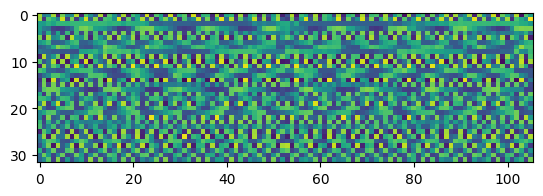

In [342]:
plt.imshow(w1)

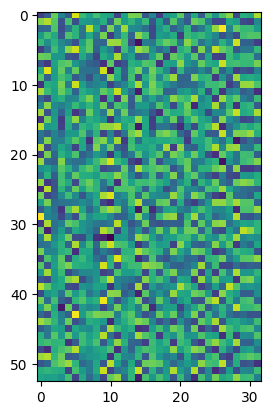

In [343]:
plt.imshow(w2)

## Fourier transform

In [344]:
def show_weights_modes(weights, title="Modes"):
  cos = t.zeros((P, P))
  sin = t.zeros((P, P))
  for i in range(P):
    for j in range(P):
      theta = t.tensor(2 * t.pi * i * j / P)
      cos[i, j] = t.cos(theta)
      sin[i, j] = t.sin(theta)
  c1 = cos @ (weights.T @ weights)
  s1 = sin @ (weights.T @ weights)
  n_plots = P // 2
  num_cols = int(math.ceil(math.sqrt(n_plots)))
  num_rows = int(math.ceil(n_plots / num_cols))
  colormap = plt.cm.rainbow
  plt.figure(figsize=(num_cols * 2, num_rows * 2))
  colors = [colormap(i) for i in np.linspace(0, 1, P)]
  for mode in range(n_plots):
    cos = c1[mode]
    sin = s1[mode]
    plt.subplot(num_rows, num_cols, mode + 1)
    color_idx = [(i * mode) % P for i in range(P)]
    color_for_mode = [colors[idx] for idx in color_idx]
    plt.scatter(cos.numpy(), sin.numpy(), c=color_for_mode)
    plt.title(f"Mode {mode}")
  plt.suptitle(title)
  norm = Normalize(vmin=0, vmax=P)
  sm = ScalarMappable(cmap=colormap, norm=norm)
  cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.01, 0.7])
  plt.colorbar(sm, cax=cbar_ax)
  plt.tight_layout(rect=[0, 0, 0.9, 1])
  plt.show()

<ipython-input-344-6e457d2b8464>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


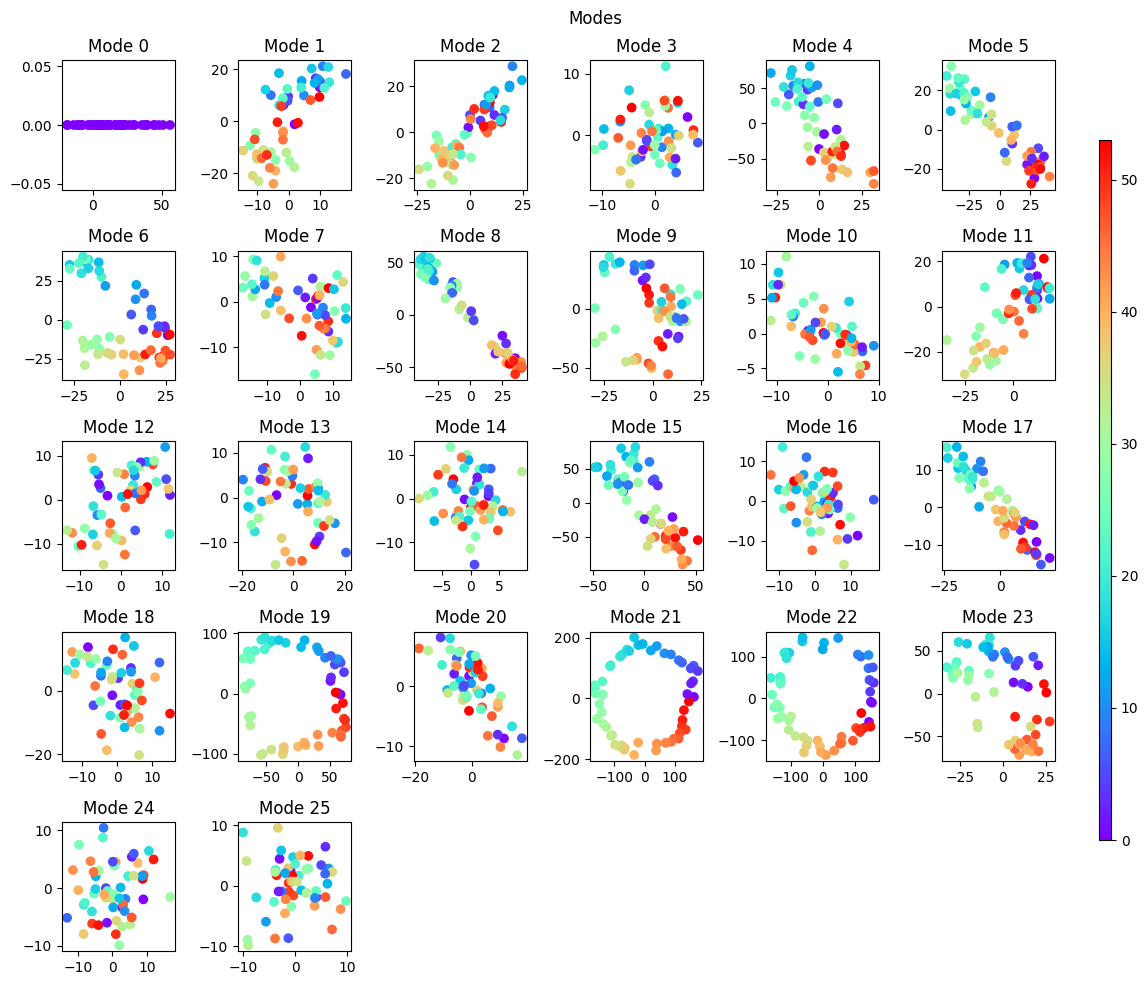

In [345]:
show_weights_modes(w1[:, :P])

<ipython-input-344-6e457d2b8464>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


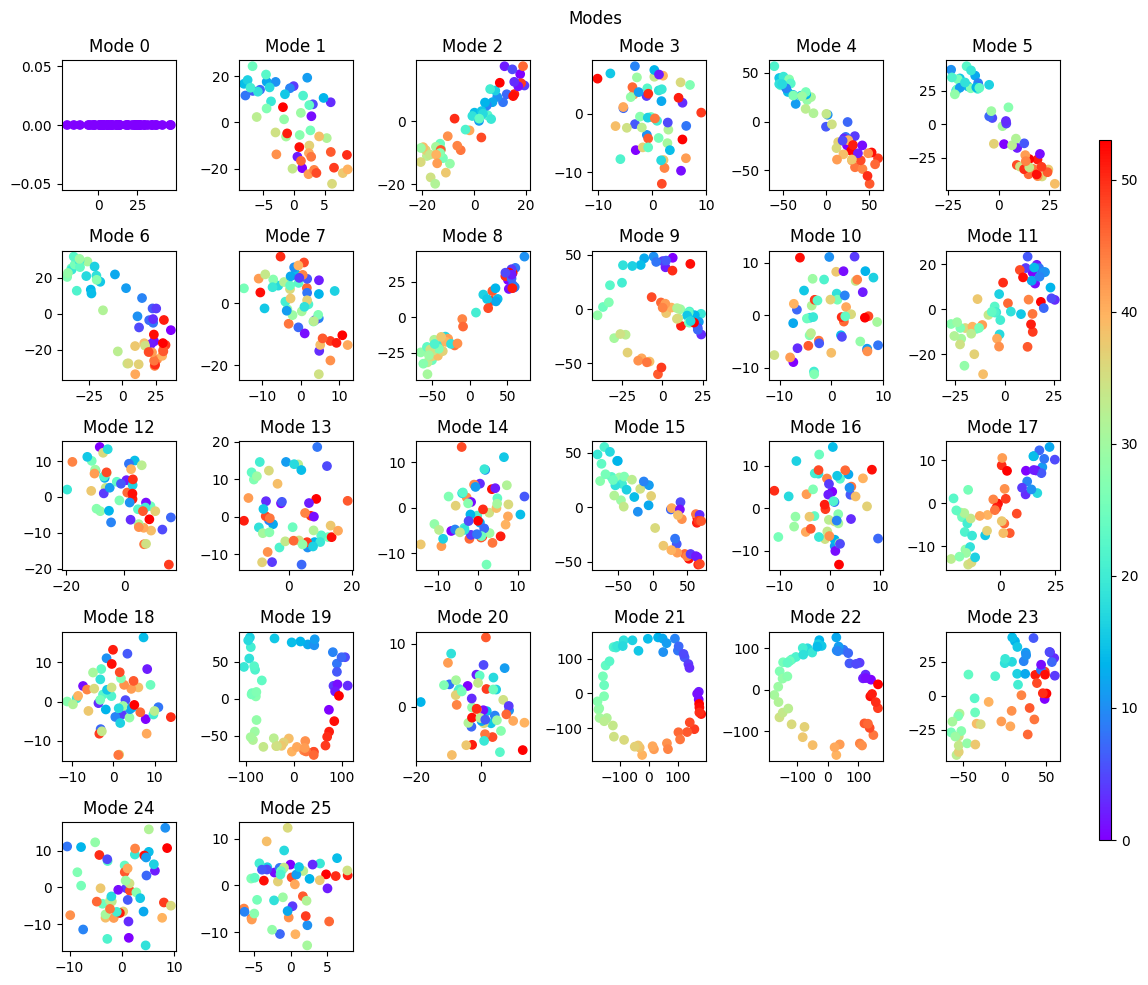

In [346]:
show_weights_modes(w1[:, P:])

<ipython-input-344-6e457d2b8464>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


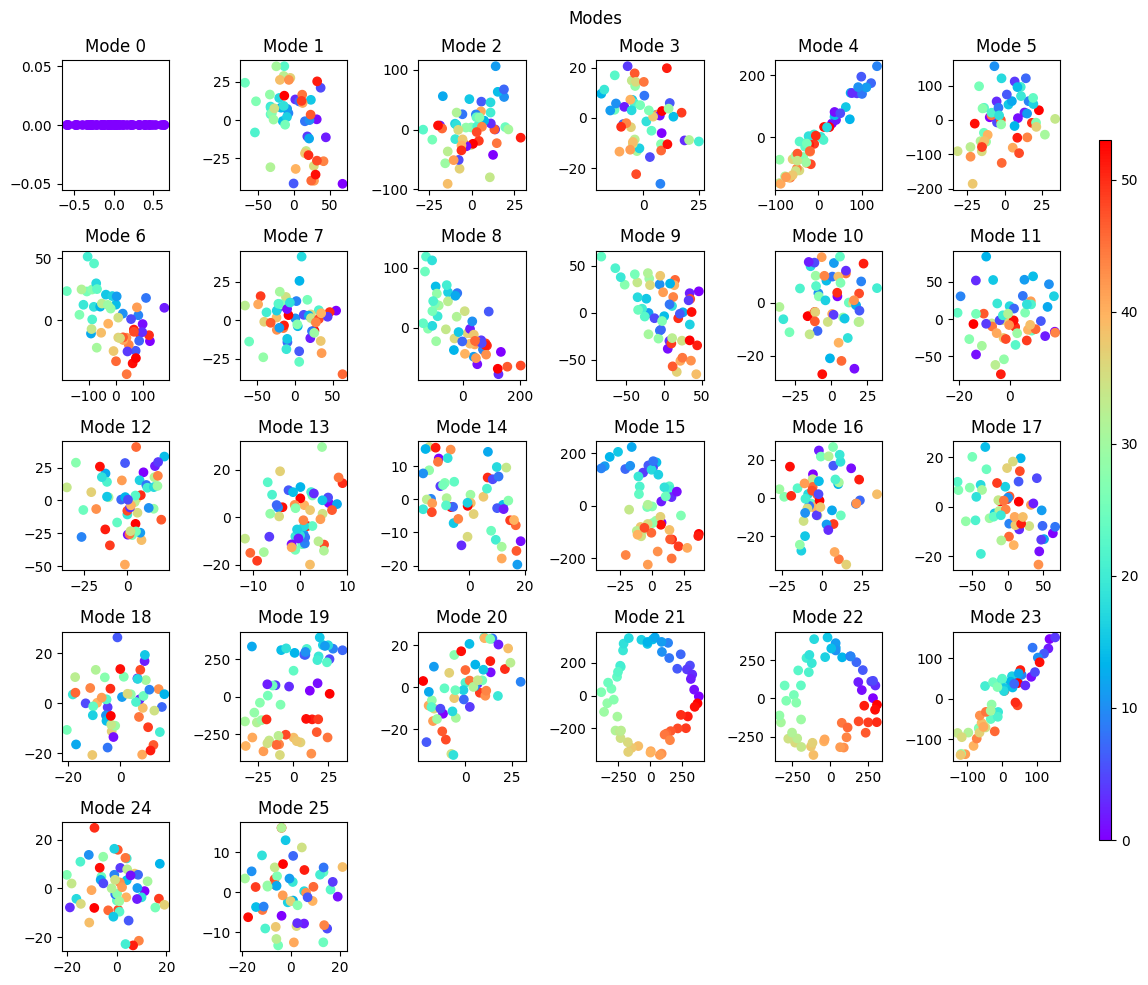

In [347]:
show_weights_modes(w2.T)

## Looking at $G_l = \mathbb{E}[D\theta_l Dθ^T]$

In [348]:
G, G2 = G.cpu(), G2.cpu()

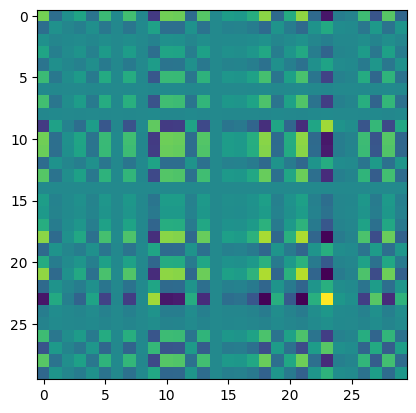

In [349]:
plt.imshow(G[:30, :30])

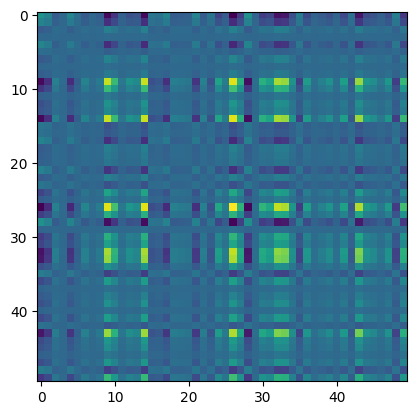

In [350]:
plt.imshow(G2[:50, :50])

### Eigenspectra

In [351]:
eig1, eigvec1 = np.linalg.eig(G)

In [352]:
eig2, eigvec2 = np.linalg.eig(G2)

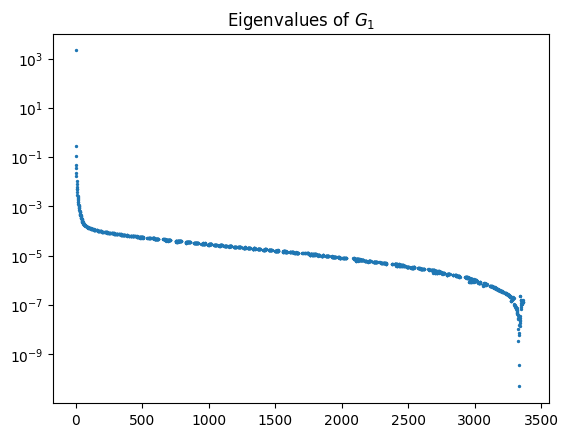

In [353]:
plt.plot()
plt.scatter(range(len(eig1)), eig1, s = 2)
plt.yscale("log")
plt.title("Eigenvalues of $G_1$")
plt.show()

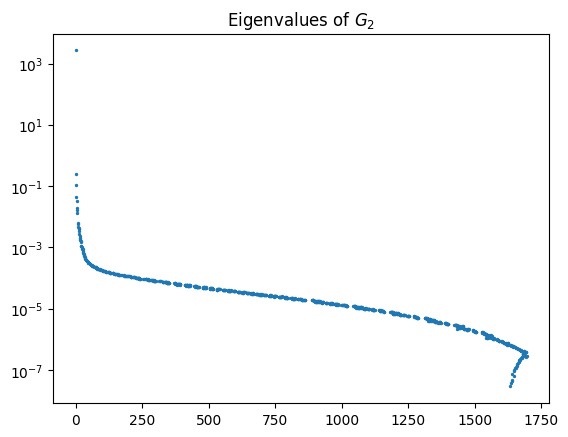

In [354]:
plt.plot()
plt.scatter(range(len(eig2)), eig2, s = 2)
plt.yscale("log")
plt.title("Eigenvalues of $G_2$")
plt.show()

Observation: top eigenvector seems to keep top Fourier modes (strong modes still look ~circular in this plot)

In [355]:
w1_eig = t.tensor(eigvec1[:, 0]).reshape(w1.shape)

<ipython-input-344-6e457d2b8464>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


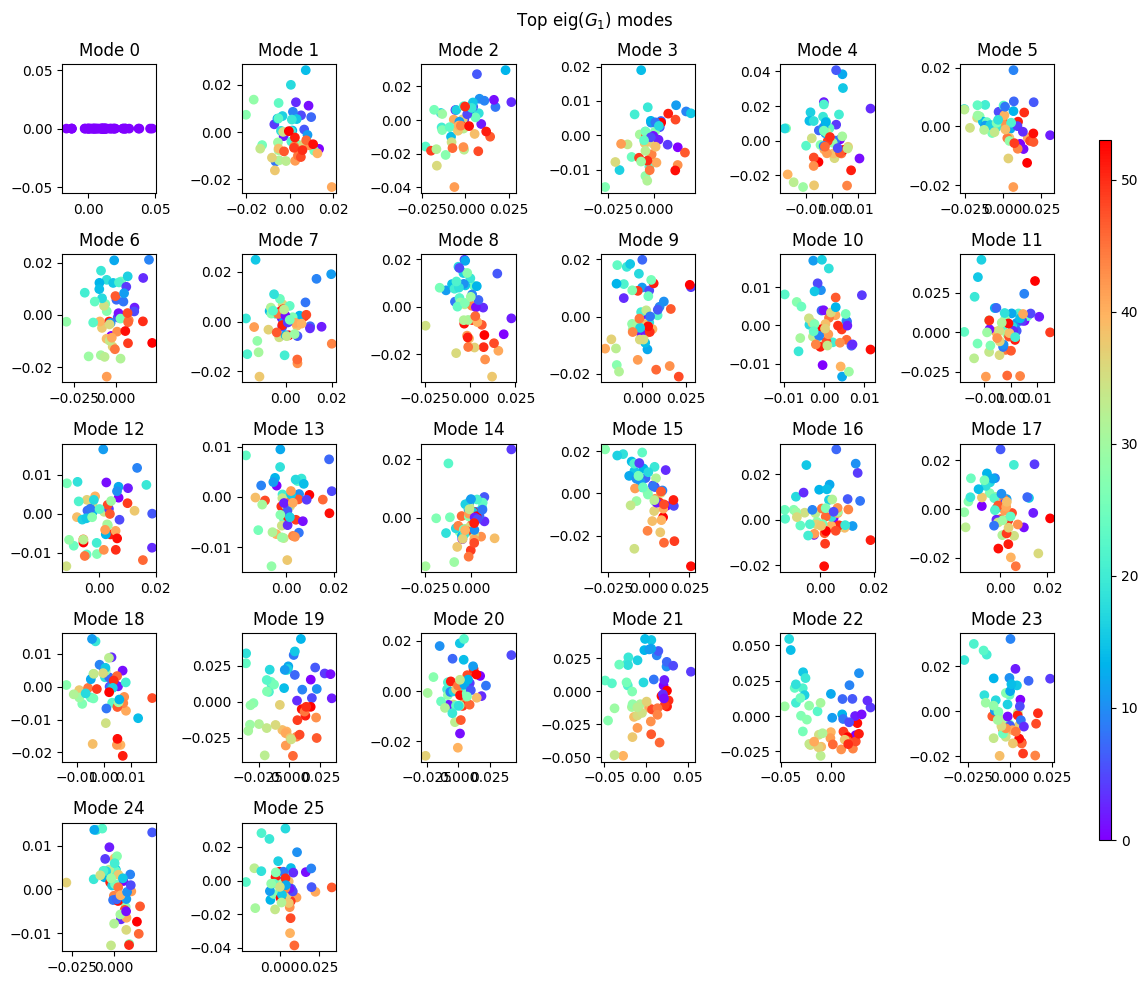

In [356]:
show_weights_modes(w1_eig[:, :P], title="Top eig($G_1$) modes")

In [357]:
w2_eig = t.tensor(eigvec2[:, 0]).reshape(w2.shape)

<ipython-input-344-6e457d2b8464>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


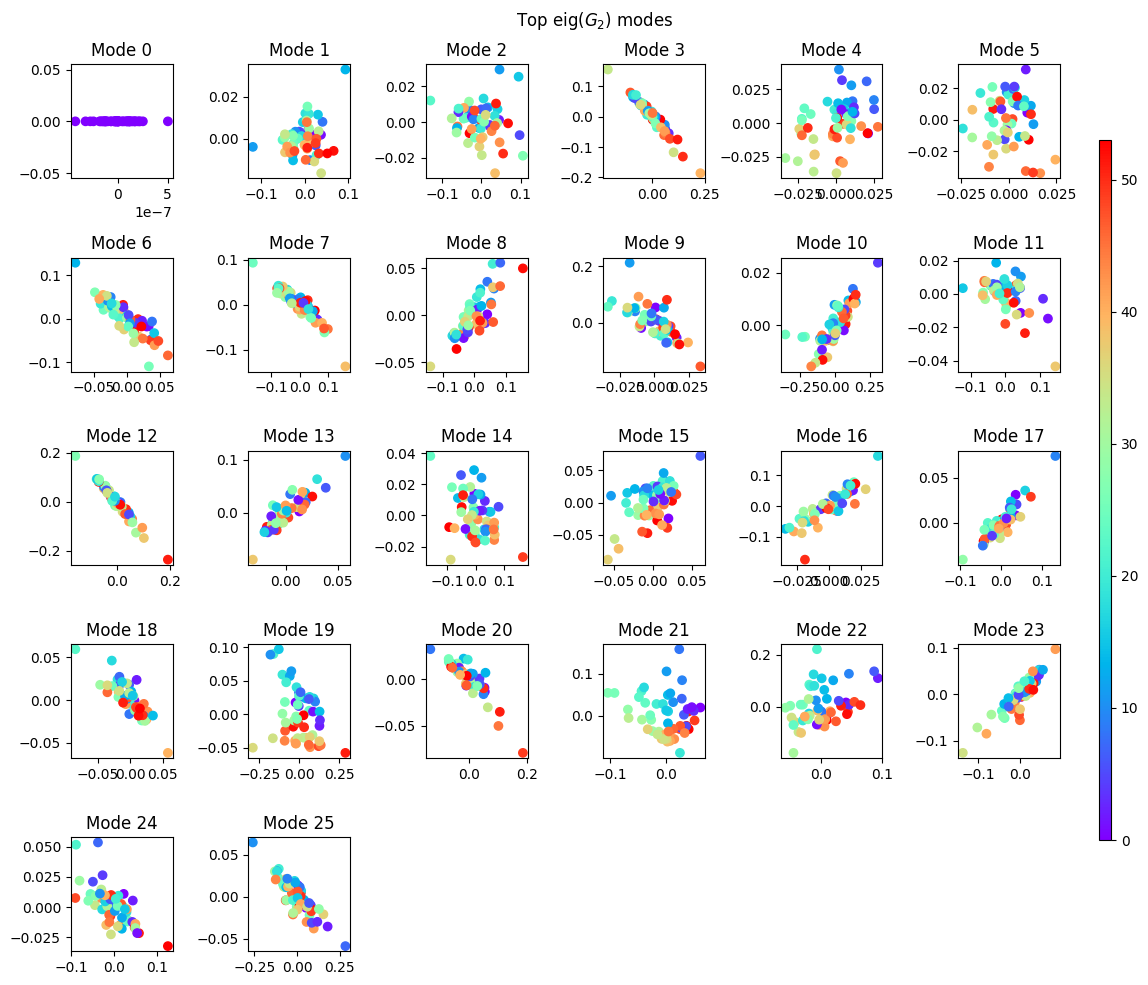

In [358]:
show_weights_modes(w2_eig.T, title="Top eig($G_2$) modes")